# Project Description

**Create a 4D dataset of 3D sub-volumes from a dense EM volume as well as the corresponding GT sag.mask sub-volume dataset.**

The notebook works through the following steps:

* Apply a 3D center crop to the 3D data, segmentations, and masks
* Apply the masks to the data to crop out the background
* Upsample the croped and masked data, as well as the GT segmenations, along x-y plane.
* Store the croped, masked, and upsampled data, as well as the segmentatios, as 3D arrays
* Split the saved 3D volumes in to sub-volumes
* Saver the sub-volumes to two different tiffi files

In [62]:
# image manipulation
import cv2
import numpy as np
from PIL import Image
from skimage.transform import resize
from skimage.util import img_as_ubyte

# data format handling
import tifffile
import h5py

# utility, visualization, and path handling 
from tqdm import tqdm
from glob import glob
from matplotlib import pyplot as plt

# system configurations handling
from yacs.config import CfgNode as CN

# 3D tensor handling
import torch
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import csv
from shutil import copyfile

from connectomics.data.utils import *
from connectomics.data.utils import getSegType



In [45]:
def cast2dtype(segm):
    """Cast the segmentation mask to the best dtype to save storage.
    """
    max_id = np.amax(np.unique(segm))
    m_type = getSegType(int(max_id))
    return segm.astype(m_type)

# System configurations

In [46]:
_C = CN()

# paths to the source images, corresponding segmentation masks and crop masks
_C.TIFIMG = '/n/pfister_lab2/Lab/vcg_connectomics/EM/zebraFish/benchmark/crop_em2.tif'
_C.H5MASK = '/n/pfister_lab2/Lab/vcg_connectomics/EM/zebraFish/benchmark/mask_gt.h5'
_C.H5SEGGT = '/n/pfister_lab2/Lab/vcg_connectomics/EM/zebraFish/benchmark/seg_gt.h5'

# if tiles false
_C.SAVEA_TRAIN = '/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/trainA/'
_C.SAVEA_TEST = '/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/testA/'
_C.SAVEGT = '/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/gt_seg_mask/'

_C.SCALE = [3,3] 
_C.IMG_SHAPE = (1450, 2000)
_C.IMG_LEN = 397


_C.D_BOUND_0 = 0
_C.D_BOUND_1 = 255
_C.H_BOUND_0 = 766 - 200//2
_C.H_BOUND_1 = 766 + 200//2
_C.W_BOUND_0 = 750 - 200//2
_C.W_BOUND_1 = 750  + 200//2

_C.TARGET_SIZE = (255,512,512)


def get_cfg_defaults():
  """Get a yacs CfgNode object with default values for my_project."""
  # Return a clone so that the defaults will not be altered
  # This is for the "local variable" use pattern
  return _C.clone()

cfg = get_cfg_defaults()
#cfg.merge_from_file("./configs/base_setup.yaml")
cfg.freeze()

# Data

#### Patch the images

In [47]:
import os 
try:
    os.makedirs(cfg.SAVEA_TRAIN, exist_ok=False)
except FileExistsError as e:
    print(e)
    
import os 
try:
    os.makedirs(cfg.SAVEA_TEST, exist_ok=False)
except FileExistsError as e:
    print(e)
    
try:
    os.makedirs(cfg.SAVEGT, exist_ok=False)
except FileExistsError as e:
    print(e)

[Errno 17] File exists: '/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/trainA/'
[Errno 17] File exists: '/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/testA/'
[Errno 17] File exists: '/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/gt_seg_mask/'


In [57]:
# open the source files for reading
with tifffile.TiffFile(cfg.TIFIMG) as tif, \
        h5py.File(cfg.H5MASK) as hdf_mask, \
        h5py.File(cfg.H5SEGGT) as hdf_seg:
        
    
    # retrive the GT segmentation
    segGT = hdf_seg.get(list(hdf_seg.keys())[0])
    # retrive the masks for cropping out the background
    masks = hdf_mask.get(list(hdf_mask.keys())[0])
    
    images = np.asarray([img.asarray() for img in tif.pages[:]])
    
    # crop volume
    images_croped = images[cfg.D_BOUND_0:cfg.D_BOUND_1,cfg.H_BOUND_0:cfg.H_BOUND_1,cfg.W_BOUND_0:cfg.W_BOUND_1]
    masks_croped = masks[cfg.D_BOUND_0:cfg.D_BOUND_1,cfg.H_BOUND_0:cfg.H_BOUND_1,cfg.W_BOUND_0:cfg.W_BOUND_1]
    segGT_croped = segGT[cfg.D_BOUND_0:cfg.D_BOUND_1,cfg.H_BOUND_0:cfg.H_BOUND_1,cfg.W_BOUND_0:cfg.W_BOUND_1]
    
    final_image_volume = np.zeros(cfg.TARGET_SIZE).astype(np.uint8)
    
    final_seg_volume = np.zeros(cfg.TARGET_SIZE).astype(np.uint64)
    
    assert(images_croped.shape == (255, 200, 200)), f"the actual shape is {final_seg_volume.shape}"

    # preprocess the images: discard outer sclices, mask, zoom
    # iterate over the images and their corresponding names
    for i, img in tqdm(enumerate(images_croped)):            

        # 1. Mask the image 
        img[masks_croped[i,:,:]==0] = 0

        # 2. Upsample the image and GT mask
        # use bilinear upsampling for the images
        img = resize(img, cfg.TARGET_SIZE[1:], order=3, preserve_range=True, anti_aliasing=False)

        assert(img.shape == cfg.TARGET_SIZE[1:]), f"the actual shape is {img.shape}"

        final_image_volume[i, :, :] = img
        
        # use NN upsampling for the label
        seg = resize(segGT_croped[i,:,:], cfg.TARGET_SIZE[1:], order=0, anti_aliasing=False, preserve_range=True)


        assert(seg.shape == cfg.TARGET_SIZE[1:]), f"the actual shape is {seg.shape}"

        final_seg_volume[i, :, :] = seg
        
        
    final_image_volume = (((final_image_volume - np.min(final_image_volume)) / float(np.max(final_image_volume)-np.min(final_image_volume))) * 255).astype(np.uint8)
    final_seg_volume = cast2dtype(final_seg_volume)
        
    assert(final_image_volume.shape == cfg.TARGET_SIZE), f"the actual shape is {final_image_volume.shape}"
    assert(final_seg_volume.shape == cfg.TARGET_SIZE), f"the actual shape is {final_seg_volume.shape}"

    #img_tif_name = 'em_3D_'+str(cfg.D_BOUND_0)+'_'+str(cfg.D_BOUND_1)+'_'+str(cfg.H_BOUND_0)+'_'+str(cfg.H_BOUND_1)+'_'+str(cfg.W_BOUND_0)+'_'+str(cfg.W_BOUND_1)+'.tif'
    img_tif_name = 'em_3D_255_512_512.tif'
    #seg_tif_name = 'seg_3D_'+str(cfg.D_BOUND_0)+'_'+str(cfg.D_BOUND_1)+'_'+str(cfg.H_BOUND_0)+'_'+str(cfg.H_BOUND_1)+'_'+str(cfg.W_BOUND_0)+'_'+str(cfg.W_BOUND_1)+'.tif'
    seg_tif_name = 'seg_3D_255_512_512.tif'
    print(os.path.join(cfg.SAVEA_TRAIN, img_tif_name))
    print(os.path.join(cfg.SAVEA_TEST, img_tif_name))
    print(os.path.join(cfg.SAVEGT, seg_tif_name))
    tifffile.imsave(os.path.join(cfg.SAVEA_TRAIN, img_tif_name), final_image_volume)
    tifffile.imsave(os.path.join(cfg.SAVEA_TEST, img_tif_name), final_image_volume)
    tifffile.imsave(os.path.join(cfg.SAVEGT, seg_tif_name), final_seg_volume)

    

4it [00:00, 35.85it/s]

254 0


255it [00:05, 42.92it/s]


255 0
/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/trainA/em_3D_255_512_512.tif
/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/testA/em_3D_255_512_512.tif
/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/gt_seg_mask/seg_3D_255_512_512.tif


In [53]:
with tifffile.TiffFile("/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/trainA/em_3D_255_512_512.tif") as train, \
     tifffile.TiffFile("/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/gt_seg_mask/seg_3D_255_512_512.tif") as seg, \
     tifffile.TiffFile("/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/testA/em_3D_255_512_512.tif") as test :
    train = np.asarray([e.asarray() for e in train.pages[:]])
    test = np.asarray([e.asarray() for e in test.pages[:]])
    seg = np.asarray([s.asarray() for s in seg.pages[:]])
    
    assert(train.dtype == "uint8"), "The input image volume should be of type uint8"
    assert(test.dtype == "uint8"), "The input image volume should be of type uint8"
    assert(seg.dtype in ["uint8" ,"uint16", "uint32", "uint64"]), "The input label volume should be of type uint8 | uint16 | uint32 | uint64"

    print(f"The lable data type is {seg.dtype}")
    
    assert(train.shape == (255,512,512)), "The input image volume most have shape (255,512,512)"
    assert(test.shape == (255,512,512)), "The input image volume most have shape (255,512,512)"
    assert(seg.shape == (255,512,512)), "The input image volume most have shape (255,512,512)"
    
    print("All good!")


The lable data type is uint32
All good!


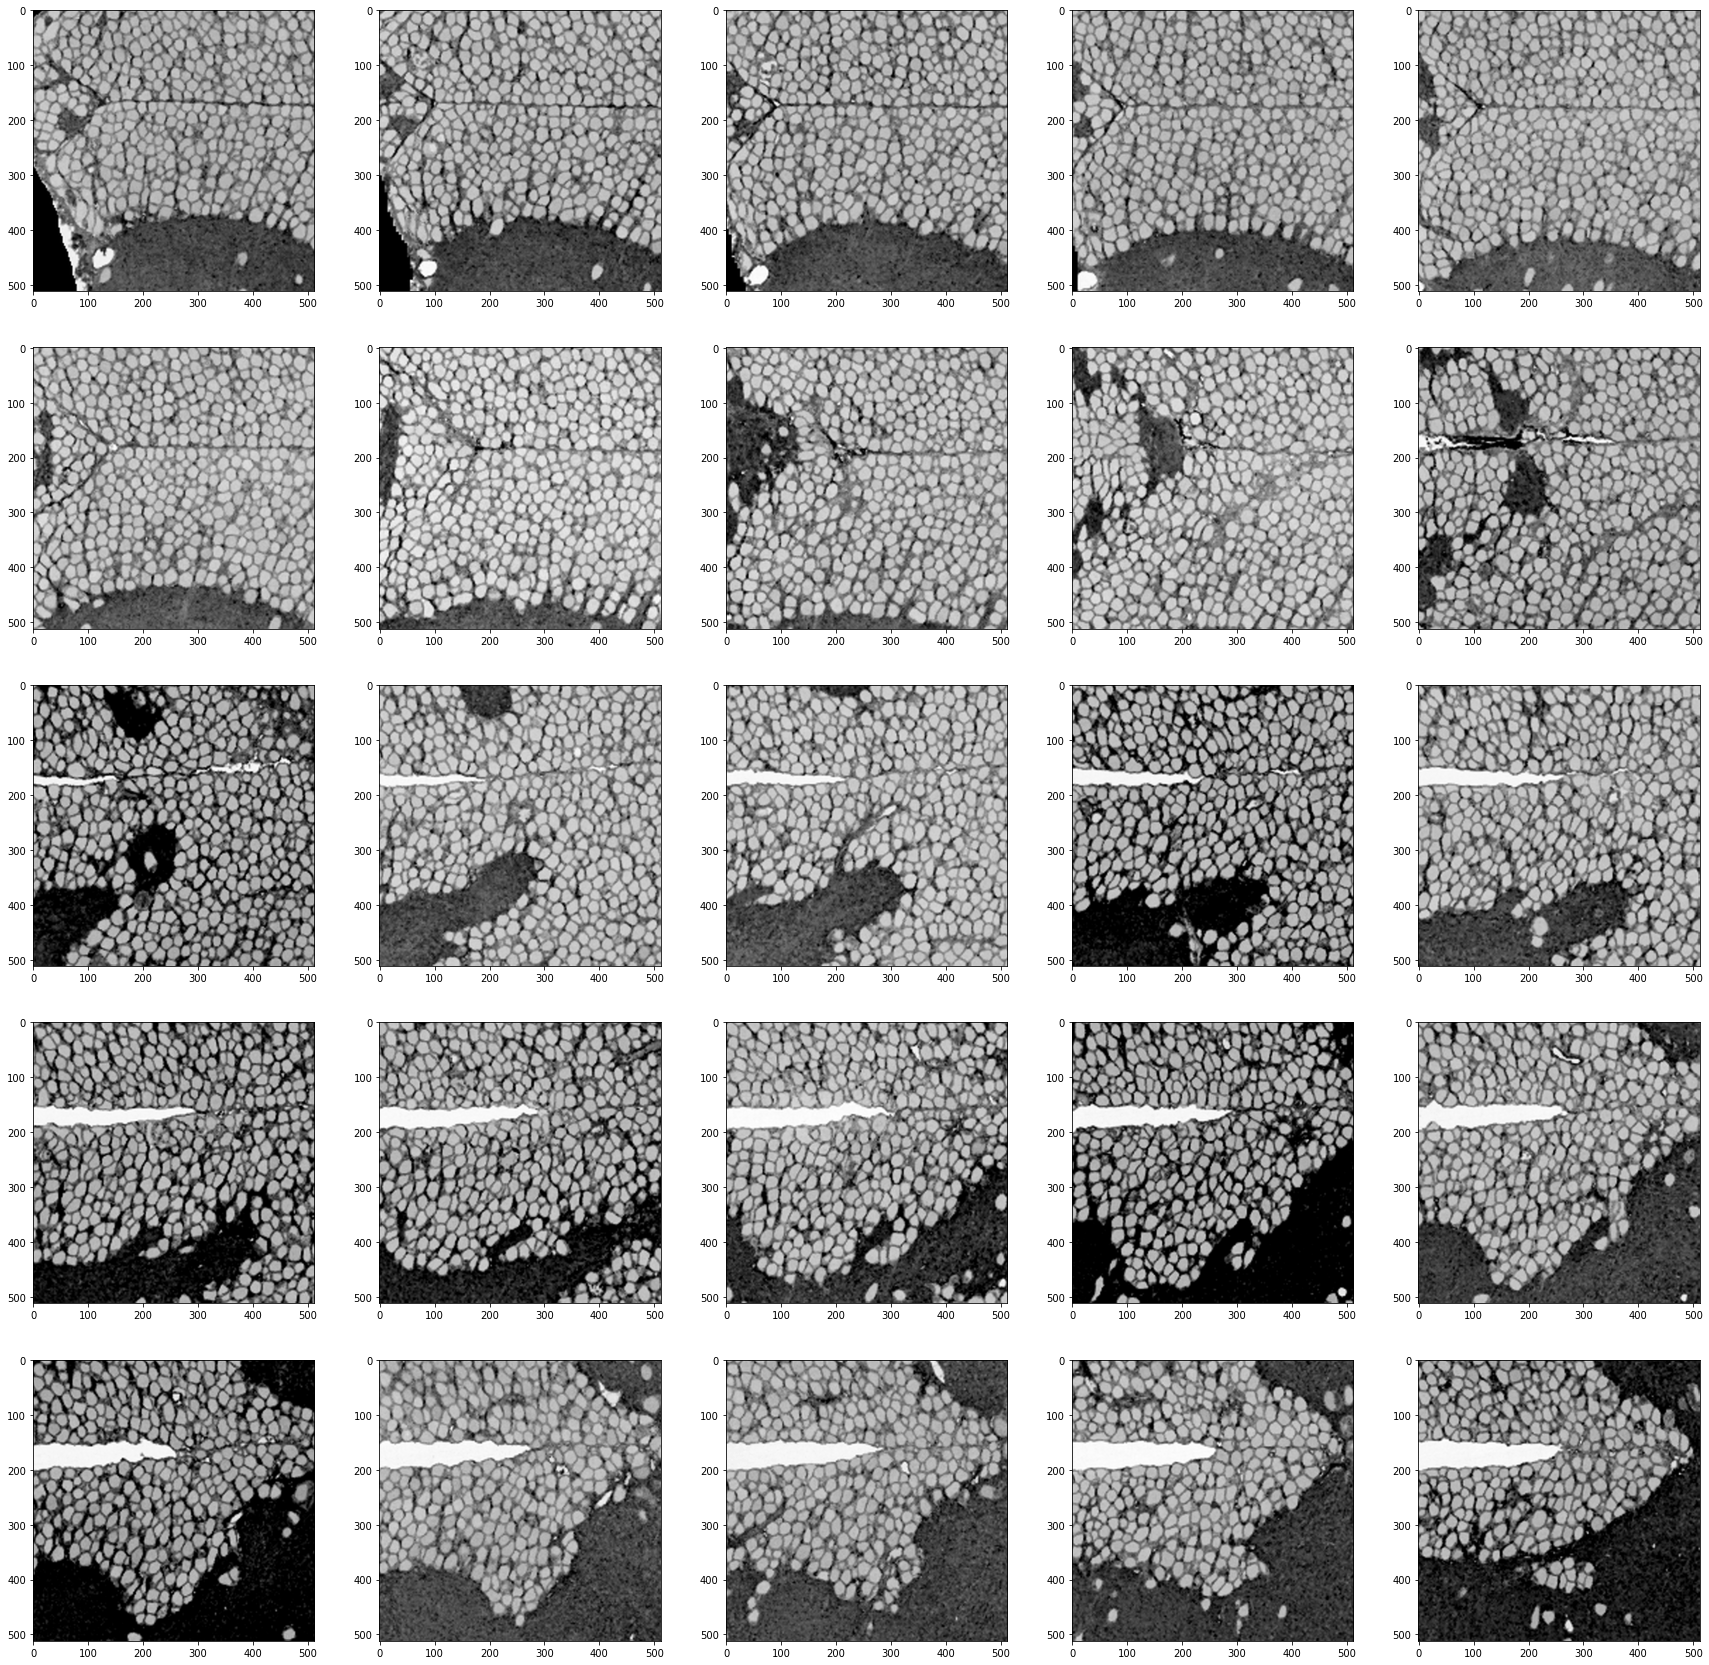

In [54]:
with tifffile.TiffFile("/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/trainA/em_3D_255_512_512.tif") as tif:
    images = np.asarray([img.asarray() for img in tif.pages[:]])
    
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(30,30))
    plt.set_cmap('gray')

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i*10,:,:])


In [63]:
with tifffile.TiffFile("/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/gt_seg_mask/seg_3D_255_512_512.tif") as tif:
    images = np.asarray([img.asarray() for img in tif.pages[:]])
    print(np.sort(np.unique(images), axis=None))
    np.savetxt("foo.csv", [np.sort(np.unique(images), axis=None)[1:]], delimiter=",", fmt="%d")

[     0     28     38 ... 170870 171873 172067]


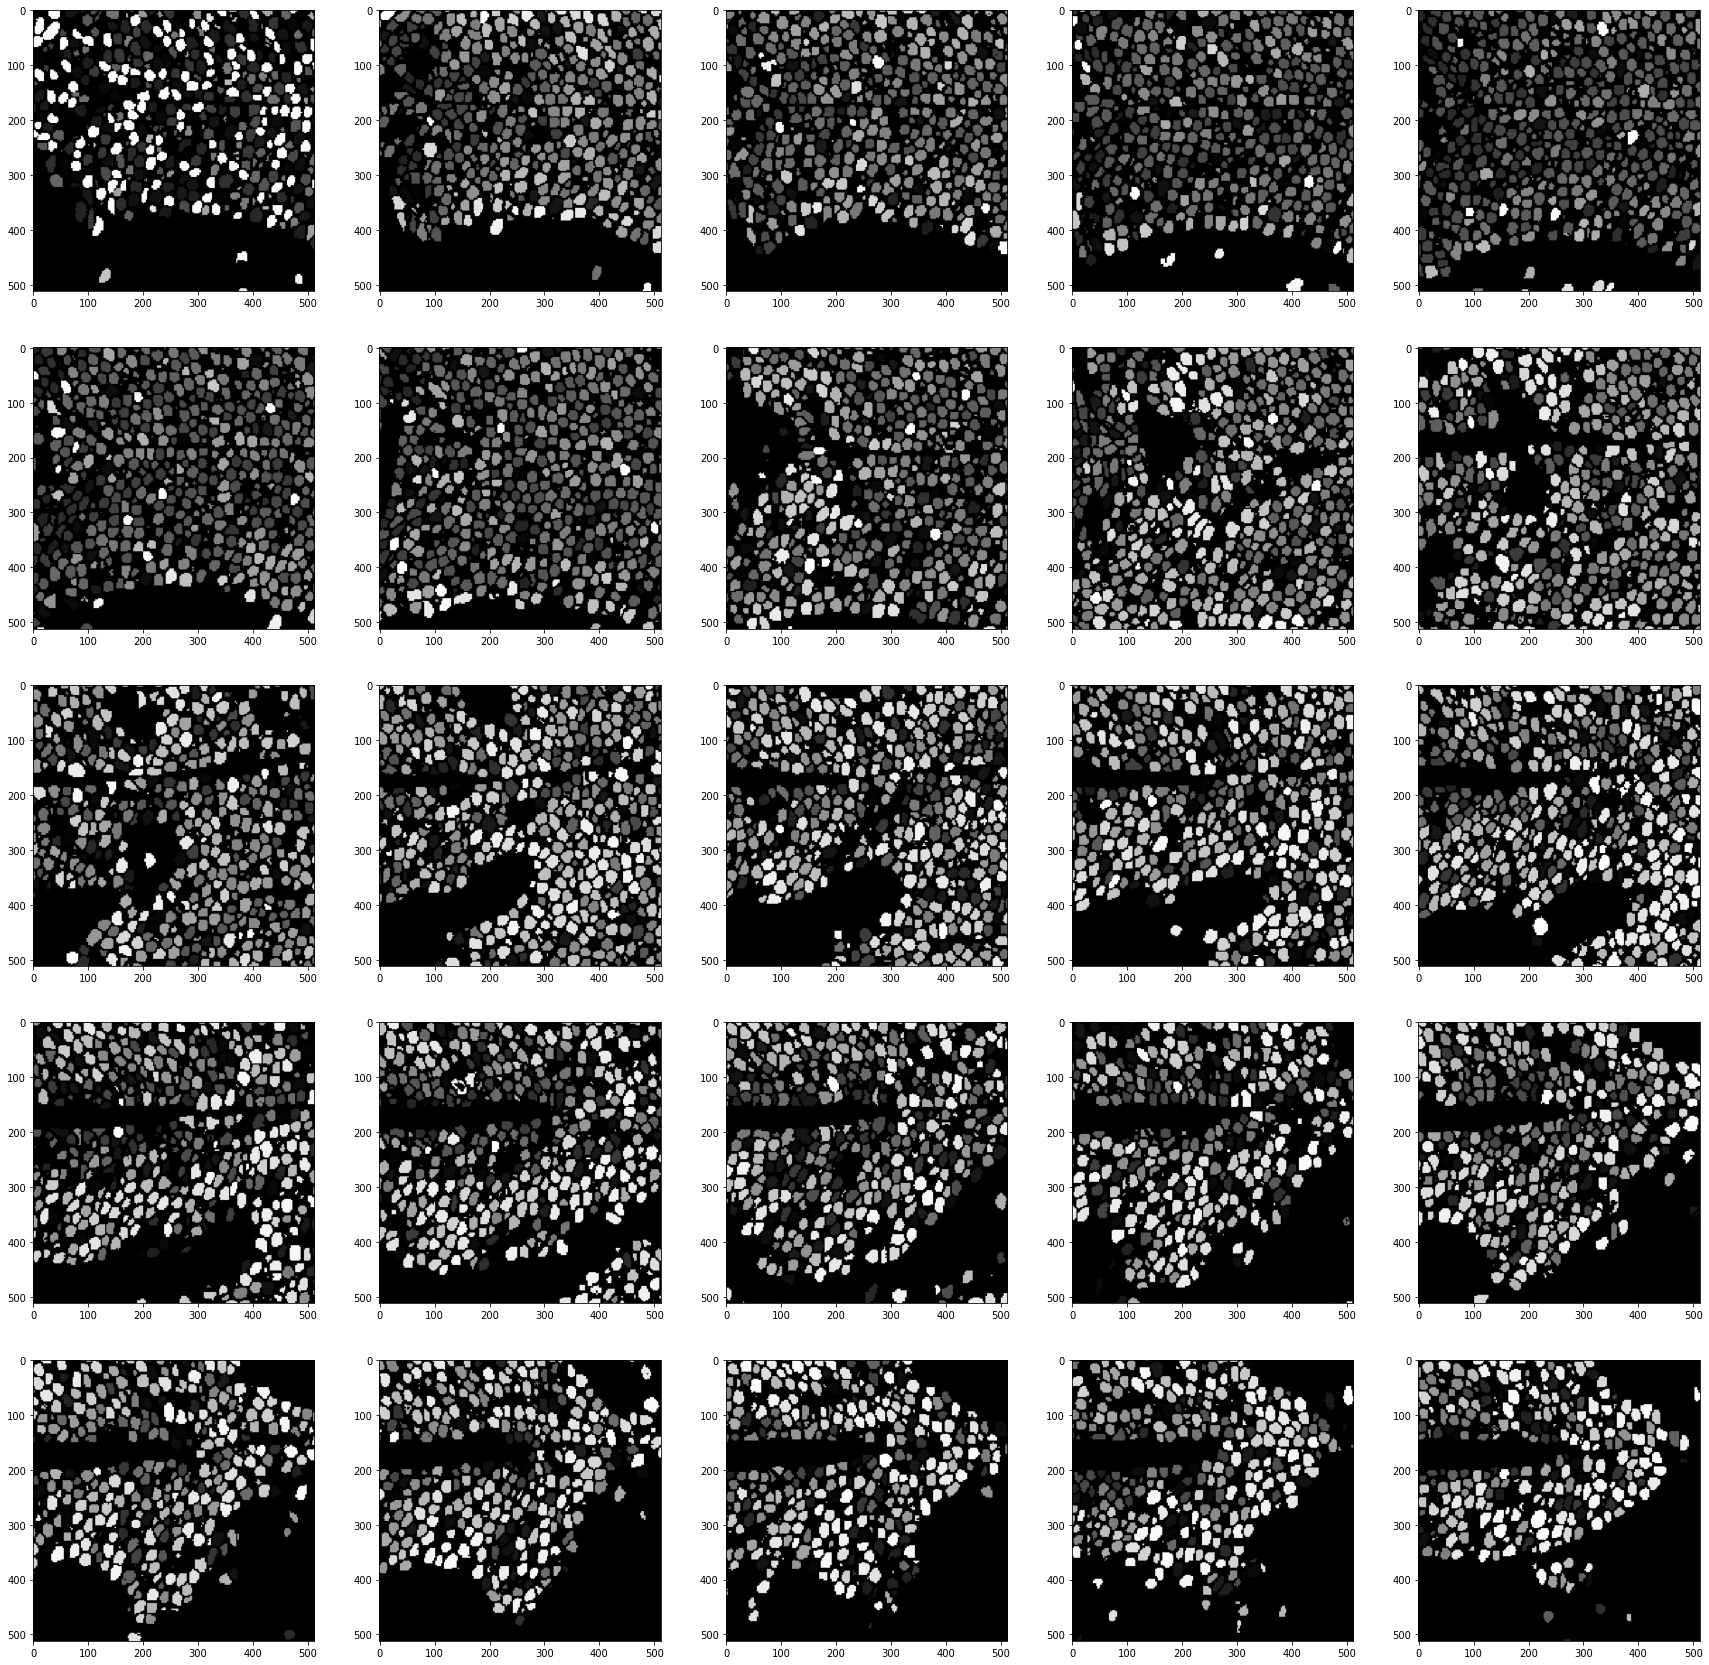

In [55]:
with tifffile.TiffFile("/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/gt_seg_mask/seg_3D_255_512_512.tif") as tif:
    images = np.asarray([img.asarray() for img in tif.pages[:]])
    
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(30,30))
    plt.set_cmap('gray')

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i*10,:,:])


(512, 512)


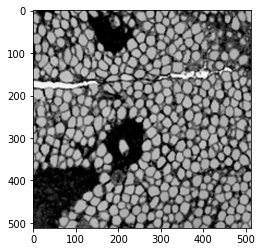

In [56]:
with tifffile.TiffFile("/n/pfister_lab2/Lab/leander/cerberus/ccgan/datasets/dorsal_crop_3D_255_512/trainA/em_3D_255_512_512.tif") as tif:
    images = np.asarray([img.asarray() for img in tif.pages[:]])
    
    plt.set_cmap('gray')
    print(images[100,:,:].shape)
    plt.imshow(images[100,:,:])

(1450, 2000)


<Figure size 432x288 with 0 Axes>

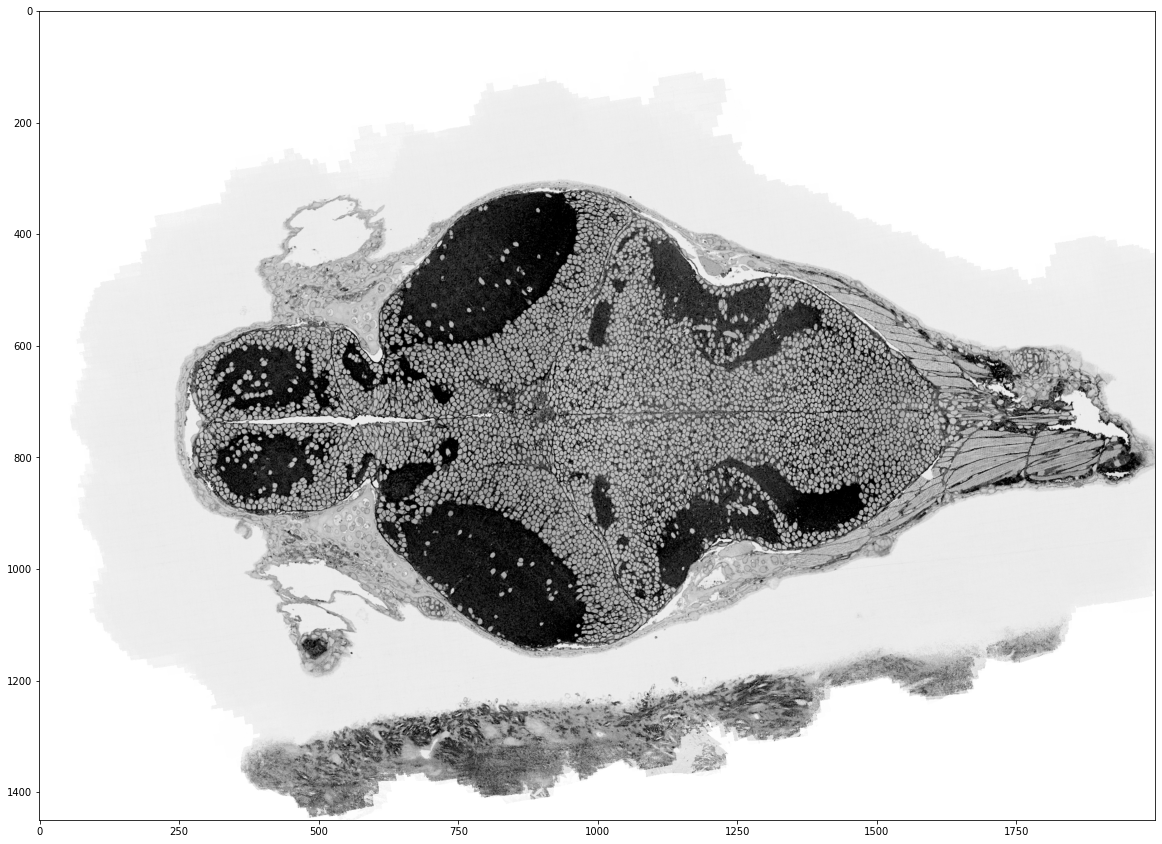

In [67]:
with tifffile.TiffFile("/n/pfister_lab2/Lab/vcg_connectomics/EM/zebraFish/benchmark/crop_em2.tif") as tif:
    images = np.asarray([img.asarray() for img in tif.pages[:]])
    
    
    plt.set_cmap('gray')
    plt.figure(figsize=(20,20))
    print(images[100,:,:].shape)
    plt.imshow(images[100,:,:])